In [11]:
import numpy as np
from matplotlib import pyplot as pl

from mlp_backprop_momentum import MLP
import k_fold_cross_validation as cv

import scipy.io.wavfile as wav
from scikits.talkbox.features import mfcc

import MFCC_computation as util
reload(util)

%matplotlib inline

In [5]:
import glob
import os

path = os.getcwd() + '/vowels'

VOWELS = glob.glob(path + '/*.wav')
assert len(VOWELS) > 0, ".wav files not found in " + path + " ! Please check the path"

FILES = {
    'natural_male': glob.glob(path + '/nam*.wav'),
    'natural_female': glob.glob(path + '/naf*.wav'),
    'natural_kid': glob.glob(path + '/nk*.wav'),
}

MFCC_COEFFS = 5

### MFCC Visualization

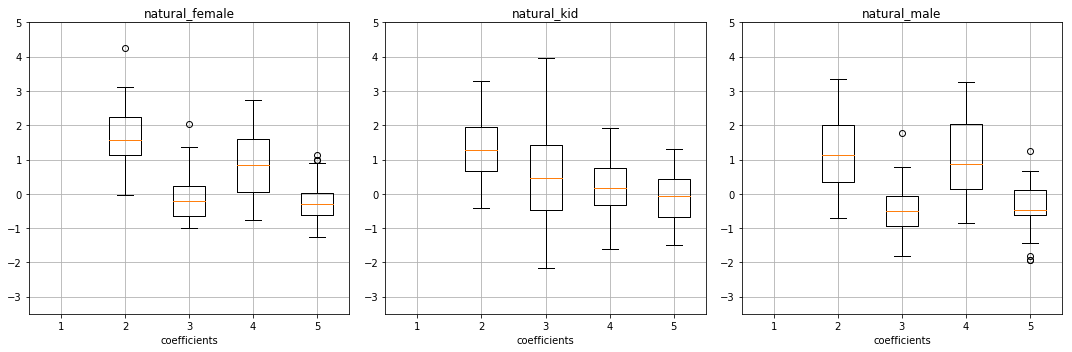

In [12]:
util.print_coeff_boxplot(['natural_female', 'natural_kid', 'natural_male'], FILES, nceps=MFCC_COEFFS, ylim=(-3.5, 5))

## MAN vs. WOMAN vs. KIS

Here we use only the natural voices of men and women to train a neural network that recognizes the gender of the speaker.

### Model complexity and learning duration

In order to choose the correct learning duration and the modely complexity, we iterate over the number of epochs (`EPOCHS`) and number of hidden neurons (`N_NEURONS`).

testing 32 neurons...


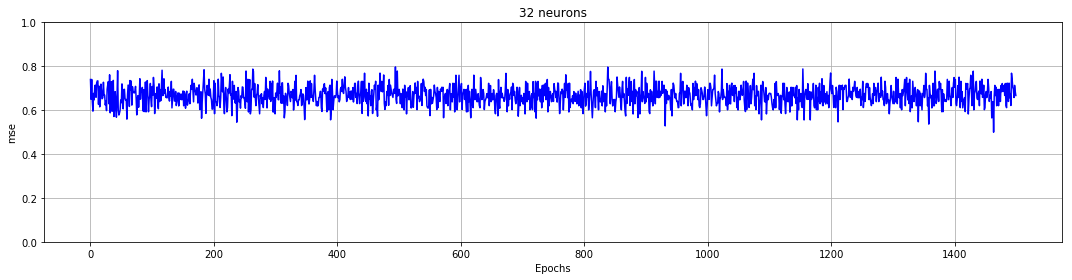

In [14]:
N_INITS = 1
EPOCHS = 1500
#N_NEURONS = [2, 4] #, 8, 16, 32]
N_NEURONS = [32]
LEARNING_RATE = 0.001
MOMENTUM = 0.9

dataset = util.create_dataset([('natural_kid', -1), ('natural_female', 0), ('natural_kid', 1)], FILES, MFCC_COEFFS)
dataset_input = dataset[:, :-1]     # filter only input values (n-1 first values)
dataset_output = dataset[:, -1:]    # filter only the output class (last value)

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
for index, n_neurons in enumerate(N_NEURONS):
    print 'testing', n_neurons, 'neurons...'
    nn = MLP([MFCC_COEFFS, n_neurons, 1], 'logistic')

    for i in np.arange(N_INITS):
        nn.init_weights()
        MSE[index, i, :] = nn.fit((dataset_input, dataset_output),
                                  learning_rate=LEARNING_RATE,
                                  momentum=MOMENTUM,
                                  epochs=EPOCHS)
        

util.print_mse(MSE, N_NEURONS)

In [17]:
EPOCHS = 1000
N_NEURONS = [8, 16, 32]
K = 3

Testing 8 neurons...


Testing 16 neurons...


Testing 32 neurons...


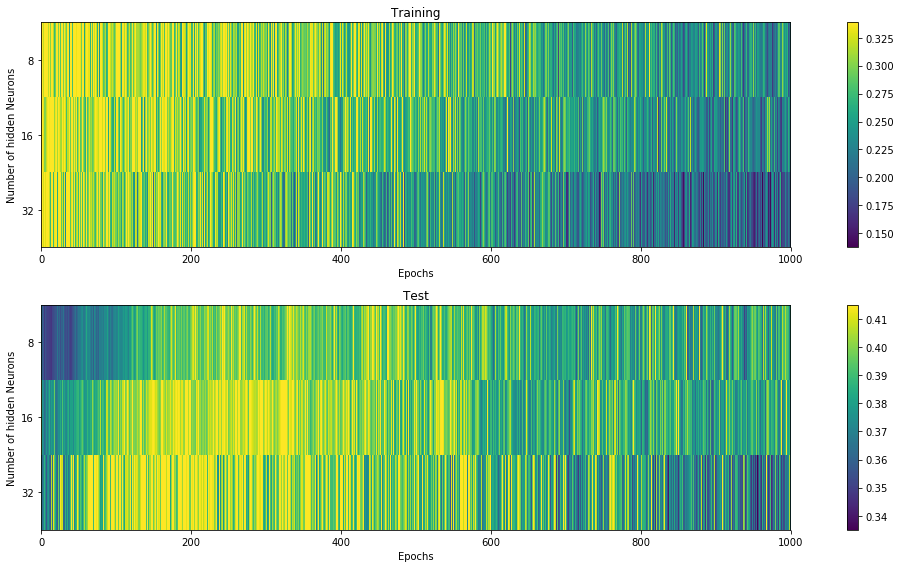

In [20]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))
reload(cv)

dataset = util.create_dataset([('natural_kid', -1), ('natural_female', 1)], FILES)

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = MLP([MFCC_COEFFS, h, 1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=0,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

util.print_mse_train_test(MSE_train, MSE_test, N_NEURONS, aspect=100)

### Final Model and performance

In [22]:
MOMENTUM = 0.5
EPOCHS = 1000
LEARNING_RATE = 0.001
N_NEURONS = 32

precision:	0.61
recall:	0.611
f1_score:	0.61
MSE training:	0.162449251861
MSE test:	0.334243135843
Confusion matrix:
[[ 20.  13.]
 [ 15.  24.]]


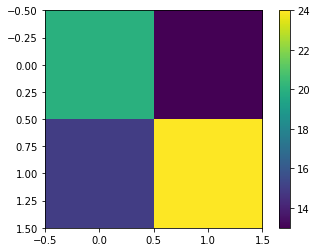

In [23]:
nn = MLP([MFCC_COEFFS, N_NEURONS, 1], 'tanh')
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                           dataset,
                                                           k=5,
                                                           learning_rate=LEARNING_RATE,
                                                           momentum=MOMENTUM,
                                                           epochs=EPOCHS,
                                                           threshold=0.0)

precision, recall, f1_score = util.conf_mat_stats(conf_mat)
print "precision:\t", np.round(precision, 3)
print "recall:\t",    np.round(recall, 3)
print "f1_score:\t",  np.round(f1_score, 3)
print 'MSE training:\t', MSE_train
print 'MSE test:\t', MSE_test
print 'Confusion matrix:'
pl.imshow(conf_mat)
pl.colorbar()
print conf_mat

conclusion here..